In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Collect Data

In [4]:
tickers_names = {"SHEL": "Shell",
                 "XOM": "ExxonMobil",
                 "BP": "BP",
                 "CVX": "Chevron"}

def FetchStockData(ticker_symbol, company_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="2021-01-01", end=today)
    
    # Reset the index and keep 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure the 'Date' column is in the correct format
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
    
    # Drop unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore')
    
    # Add additional columns for ticker and commodity
    data['ticker'] = ticker_symbol  
    data['company'] = company_name  
    
    # Convert all column names to lowercase for consistency
    data.columns = [col.lower() for col in data.columns]
    
    # Reorder columns to place 'ticker', 'commodity', and 'date' at the beginning
    data = data[['ticker', 'company', 'date'] + [col for col in data.columns if col not in ['ticker', 'company', 'date']]]
    data['date'] = pd.to_datetime(data['date'])

    return data



# 2. Loop over each symbol and append data to a DataFrame
all_data = []
for symbol, name in tickers_names.items():
    all_data.append(FetchStockData(symbol, name))

# Concatenate all the individual datasets into one
stock_data = pd.concat(all_data, ignore_index=True)
stock_data.to_csv('stock_data.csv', index = False)

stock_data.set_index('date', inplace = True)

# Inspect Data

## General

In [22]:
print("Energy Stock Prices Dataset Info:")
print(stock_data.info())

Energy Stock Prices Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ticker   4240 non-null   object        
 1   company  4240 non-null   object        
 2   date     4240 non-null   datetime64[ns]
 3   open     4240 non-null   float64       
 4   high     4240 non-null   float64       
 5   low      4240 non-null   float64       
 6   close    4240 non-null   float64       
 7   volume   4240 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 265.1+ KB
None


In [23]:
print("Energy Stock Prices Dataset Description:")
print(stock_data.describe())

Energy Stock Prices Dataset Description:
                                date         open         high          low  \
count                           4240  4240.000000  4240.000000  4240.000000   
mean   2023-02-10 07:28:18.113207552    75.753997    76.486134    75.008758   
min              2021-01-04 00:00:00    16.824344    17.190437    16.620955   
25%              2022-01-20 18:00:00    35.298640    35.638374    35.015864   
50%              2023-02-09 12:00:00    63.039891    63.416520    62.585192   
75%              2024-03-01 18:00:00   108.187955   109.175284   107.181774   
max              2025-03-24 00:00:00   169.405669   171.723312   168.554651   
std                              NaN    43.763309    44.190900    43.307818   

             close        volume  
count  4240.000000  4.240000e+03  
mean     75.760107  1.142028e+07  
min      16.881292  7.529140e+05  
25%      35.286458  5.903550e+06  
50%      62.867777  9.060150e+06  
75%     108.123268  1.463030e+07  
ma

In [24]:
print("The Number of Instances for Each Company:")
print(stock_data['company'].value_counts())

The Number of Instances for Each Company:
company
Shell         1060
ExxonMobil    1060
BP            1060
Chevron       1060
Name: count, dtype: int64


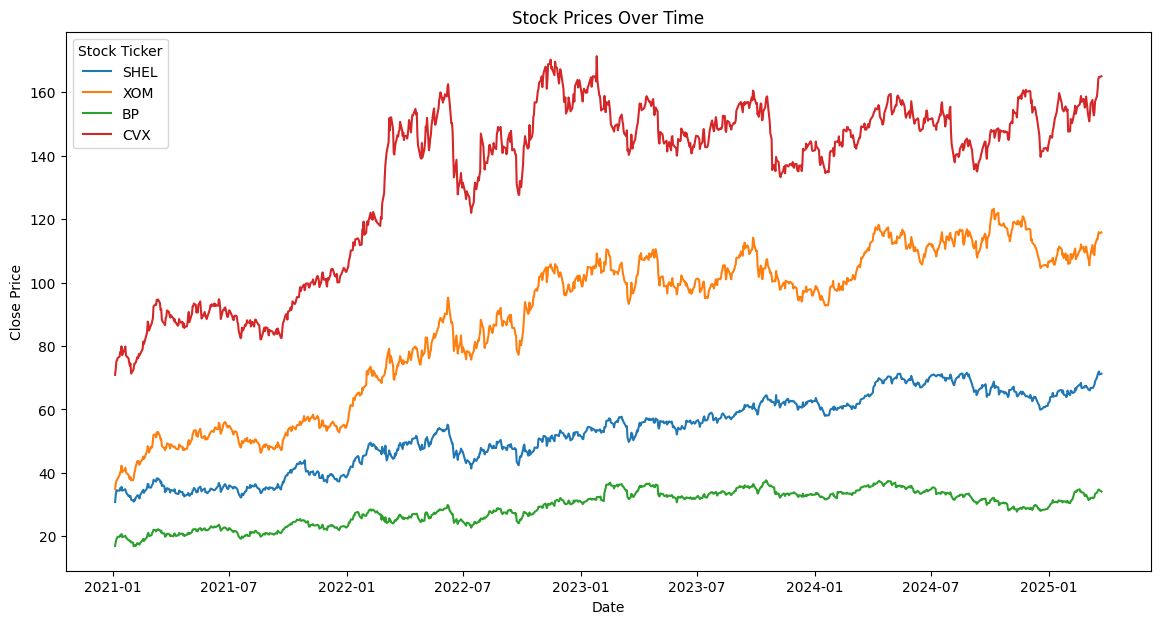

In [25]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='close', hue='ticker')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Stock Ticker')
plt.show()

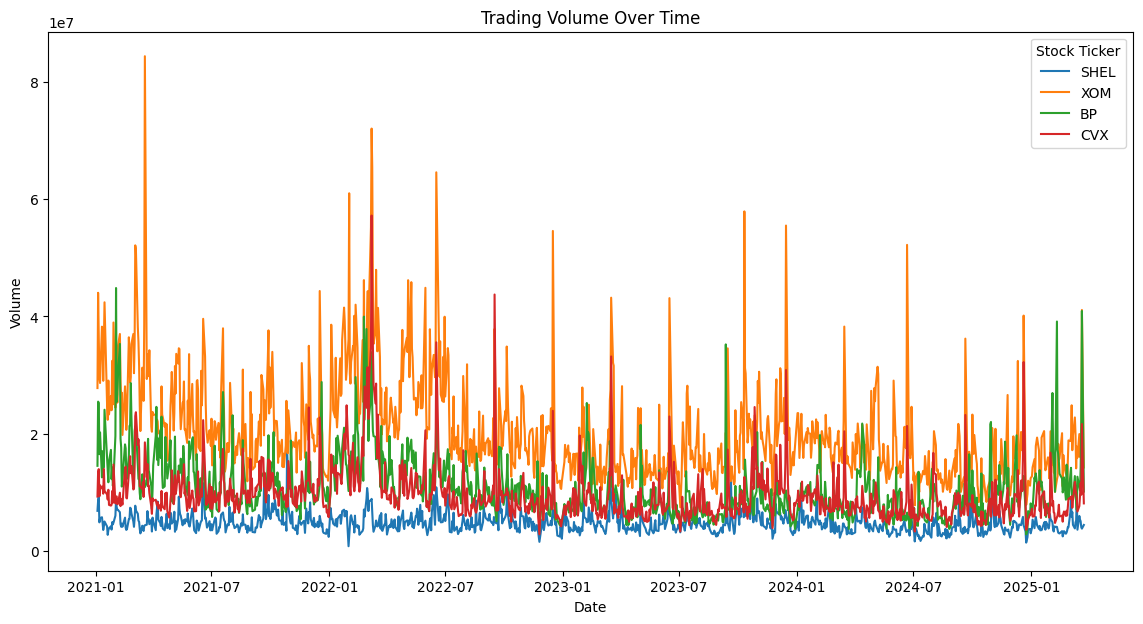

In [26]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='volume', hue='ticker')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Stock Ticker')
plt.show()

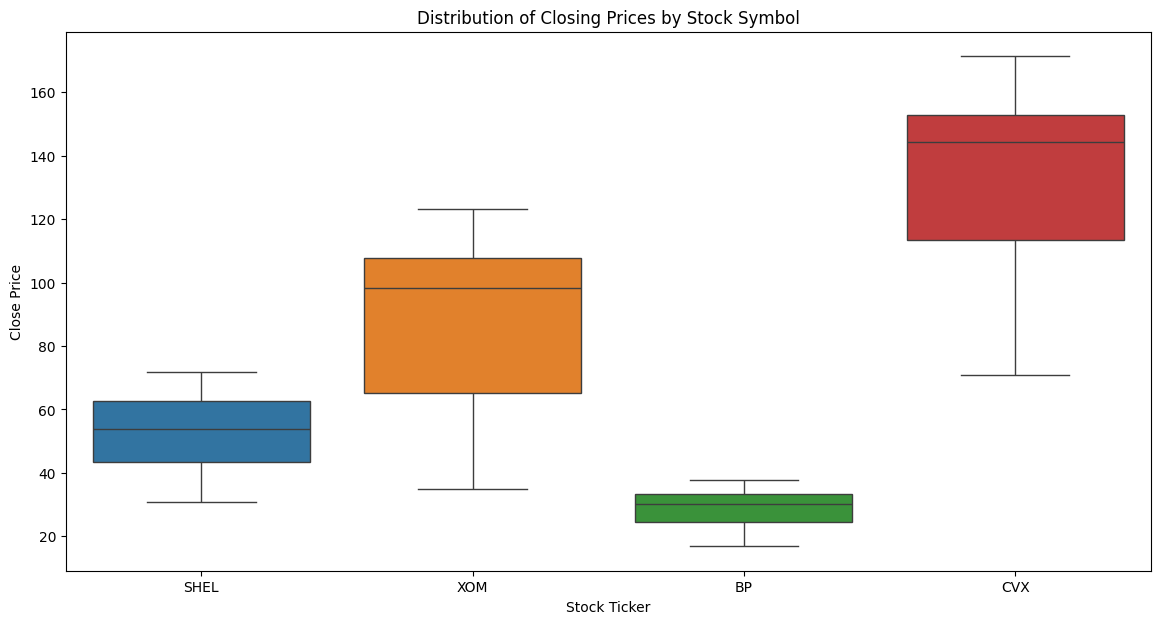

In [27]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=stock_data, x='ticker', y='close', hue='ticker')
plt.title('Distribution of Closing Prices by Stock Symbol')
plt.xlabel('Stock Ticker')
plt.ylabel('Close Price')
plt.show()

In [28]:
pivot_table = stock_data.pivot(index='date', columns='ticker', values='close')
pivot_table

ticker,BP,CVX,SHEL,XOM
date,,,,
2021-01-04,16.946371,70.881592,30.810038,34.851479
2021-01-05,18.207386,72.797775,32.930744,36.531078
2021-01-06,19.045347,75.140678,34.452858,37.463257
2021-01-07,19.452127,75.492104,34.495613,37.757168
2021-01-08,19.850771,76.211716,34.410107,38.177071
...,...,...,...,...
2025-03-18,34.220001,160.809998,70.970001,113.639999
2025-03-19,34.610001,164.050003,71.519997,115.410004
2025-03-20,34.750000,164.770004,71.949997,115.900002


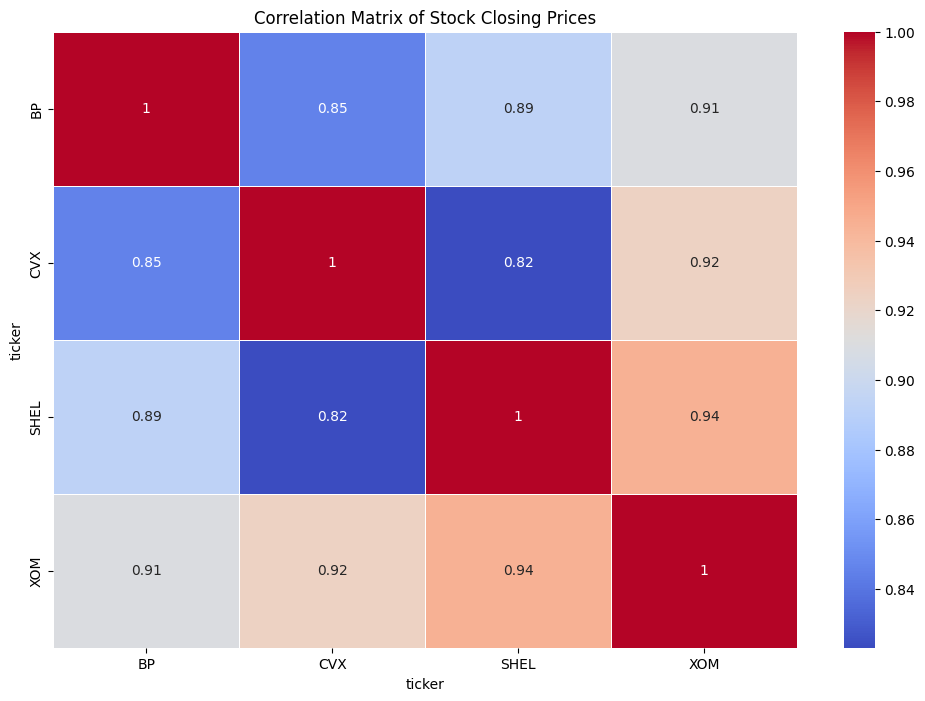

In [29]:
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Closing Prices')
plt.show()

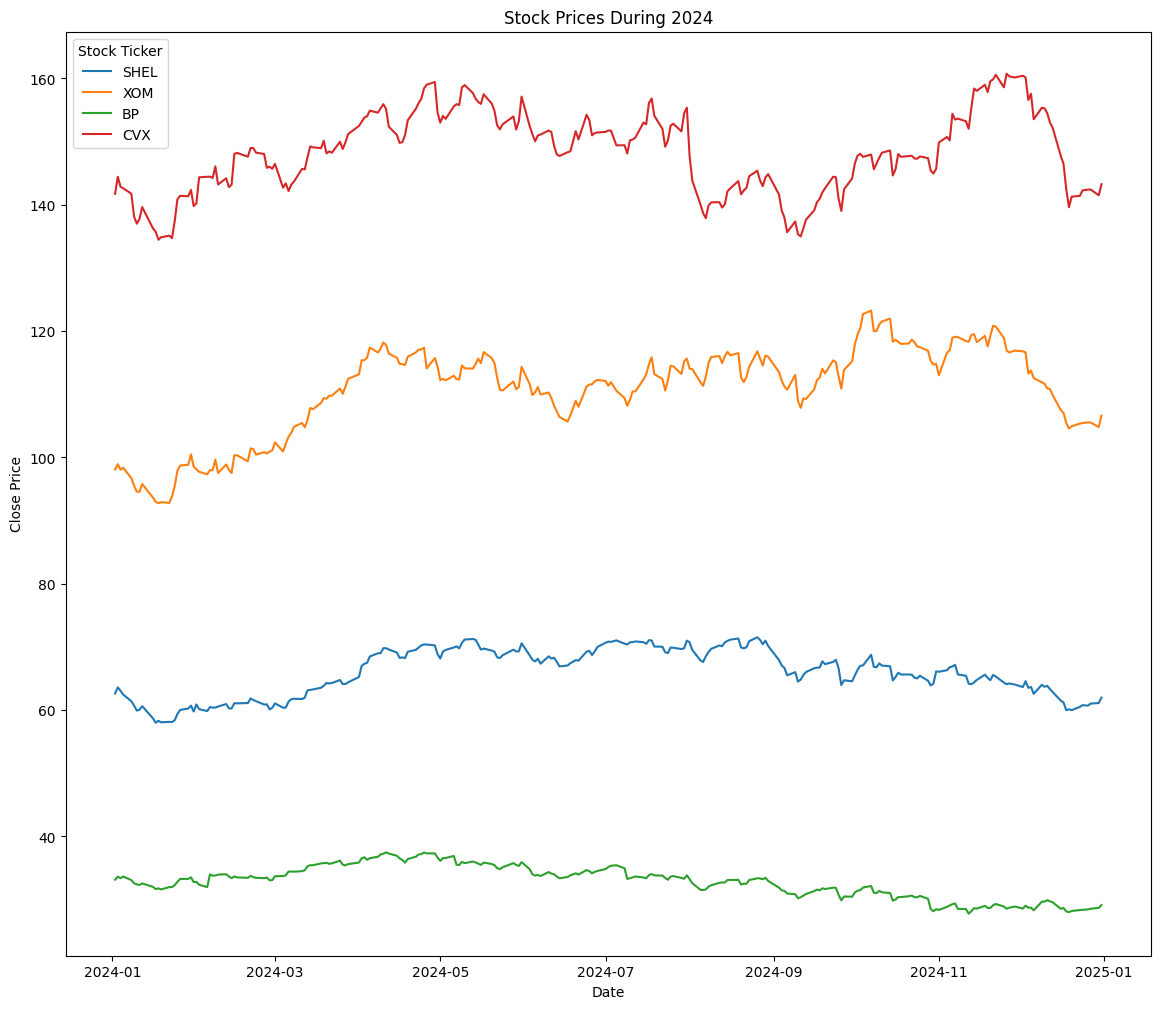

In [30]:
stock_data_2024 = stock_data[(stock_data['date'] >= '2024-01-01') & (stock_data['date'] <= '2024-12-31')]

plt.figure(figsize= (14, 12))
sns.lineplot(data = stock_data_2024, x = 'date', y = 'close', hue = 'ticker')
plt.title('Stock Prices During 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title = 'Stock Ticker')
plt.show()

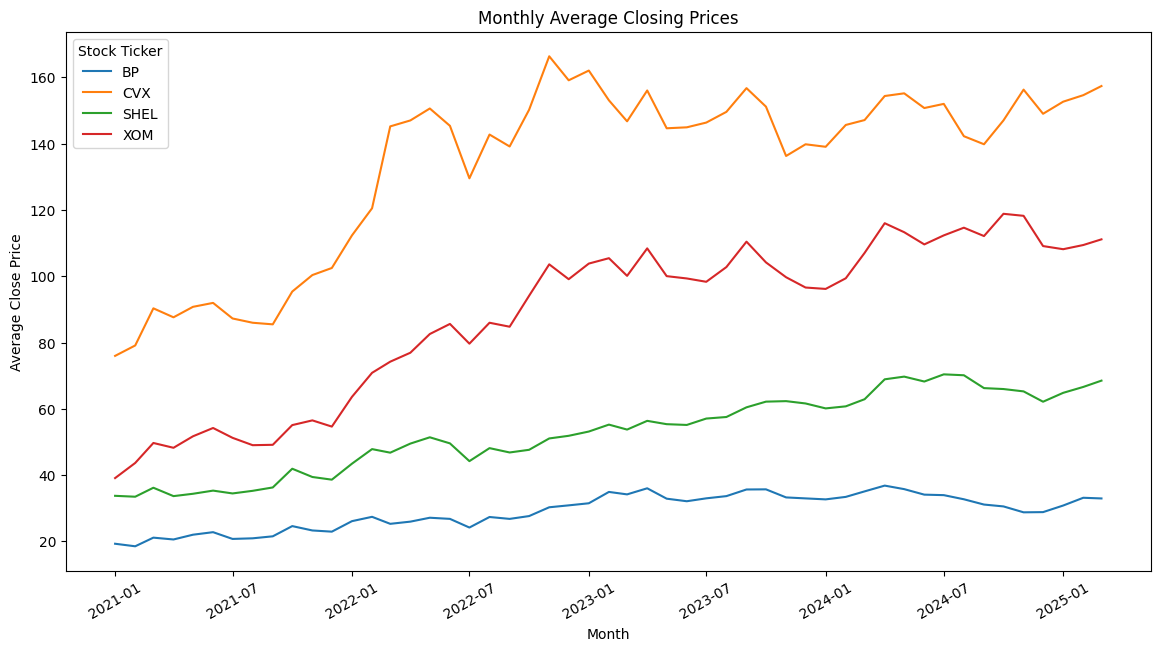

In [31]:
stock_data['month'] = stock_data['date'].dt.to_period('M').dt.to_timestamp()
monthly_avg_prices = stock_data.groupby(['month', 'ticker']).mean(numeric_only=True).reset_index()

plt.figure(figsize = (14, 7))
sns.lineplot(data = monthly_avg_prices, x = 'month', y = 'close', hue = 'ticker')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 30)
plt.legend(title = 'Stock Ticker')
plt.show()

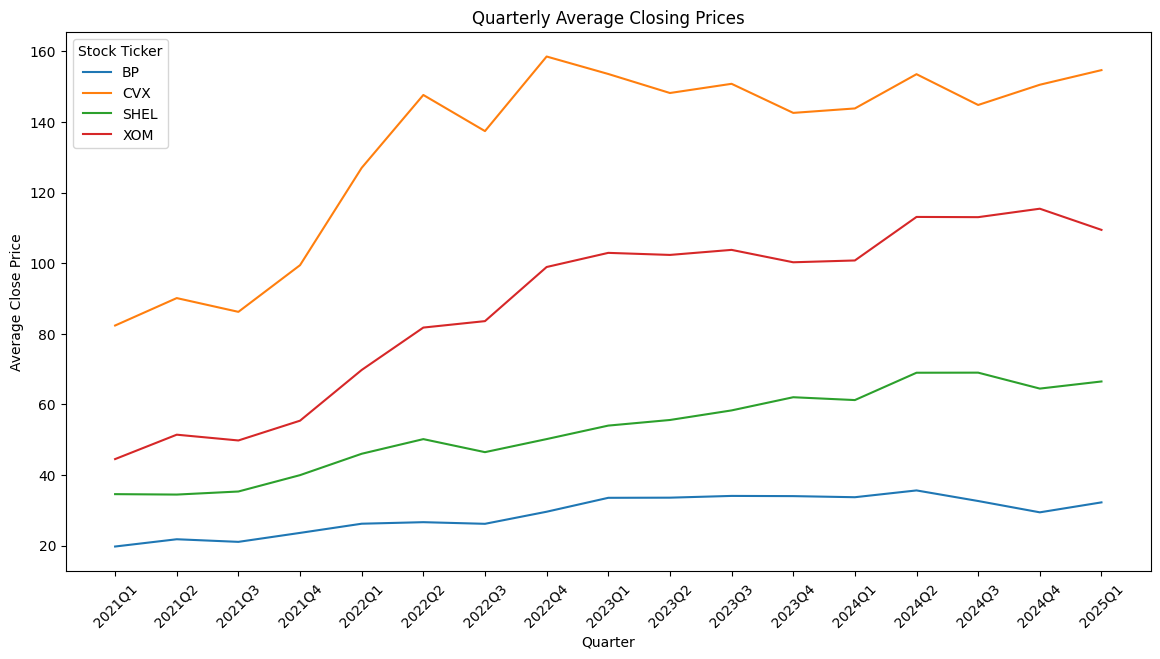

In [32]:
stock_data['quarter'] = stock_data['date'].dt.to_period('Q')
quarterly_avg_prices = stock_data.groupby(['quarter', 'ticker']).mean(numeric_only=True).reset_index()
quarterly_avg_prices['quarter'] = quarterly_avg_prices['quarter'].astype(str)

plt.figure(figsize = (14, 7))
sns.lineplot(data = quarterly_avg_prices, x = 'quarter', y = 'close', hue = 'ticker')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 45)
plt.legend(title = 'Stock Ticker')
plt.show()

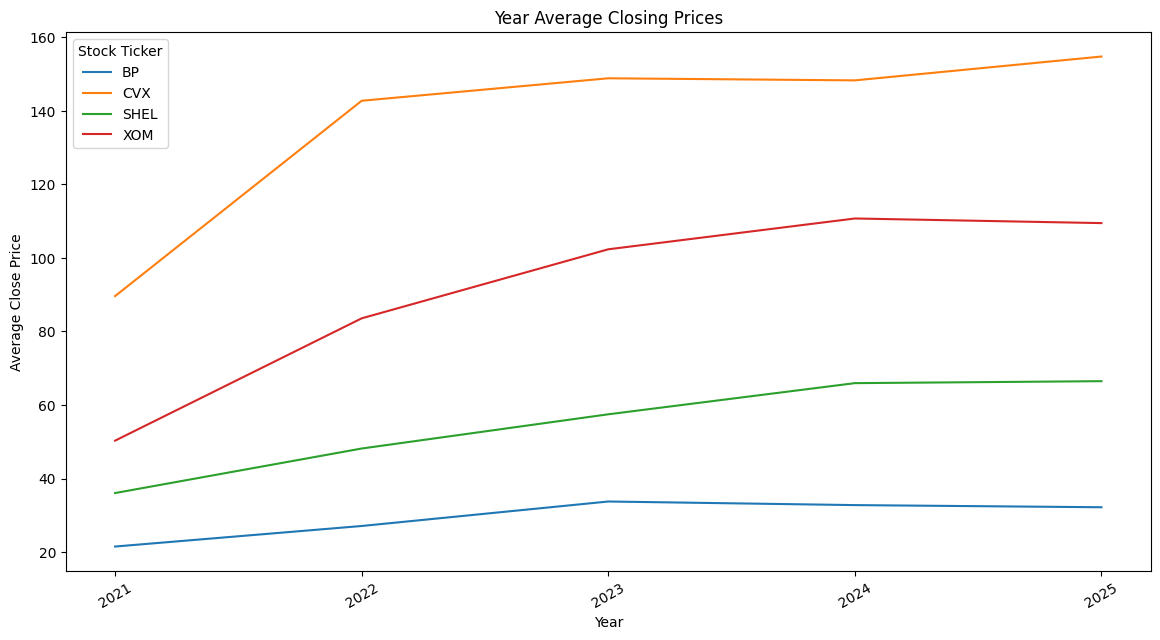

In [33]:
stock_data['year'] = stock_data['date'].dt.year
yearly_avg_prices = stock_data.groupby(['year', 'ticker']).mean(numeric_only=True).reset_index()
yearly_avg_prices['year'] = yearly_avg_prices['year'].astype(int)

plt.figure(figsize = (14, 7))
sns.lineplot(data = yearly_avg_prices, x = 'year', y = 'close', hue = 'ticker')
plt.title('Year Average Closing Prices')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.xticks(ticks=yearly_avg_prices['year'].unique(), rotation=30)
plt.legend(title = 'Stock Ticker')
plt.show()

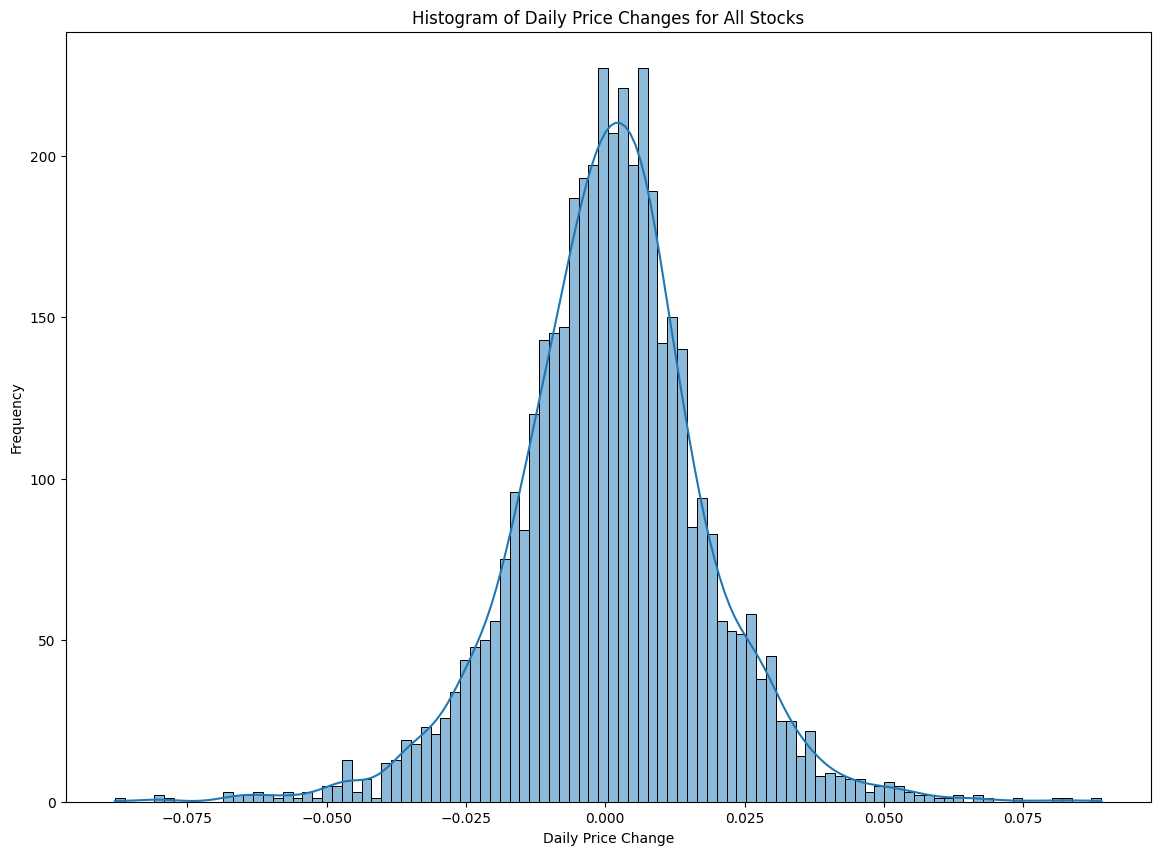

In [34]:
stock_data['price_change'] = stock_data.groupby('ticker')['close'].pct_change() # percentage change

plt.figure(figsize = (14, 10))

sns.histplot(stock_data['price_change'].dropna(), bins = 100, kde = True)
plt.title('Histogram of Daily Price Changes for All Stocks')
plt.xlabel('Daily Price Change')
plt.ylabel('Frequency')
plt.show()

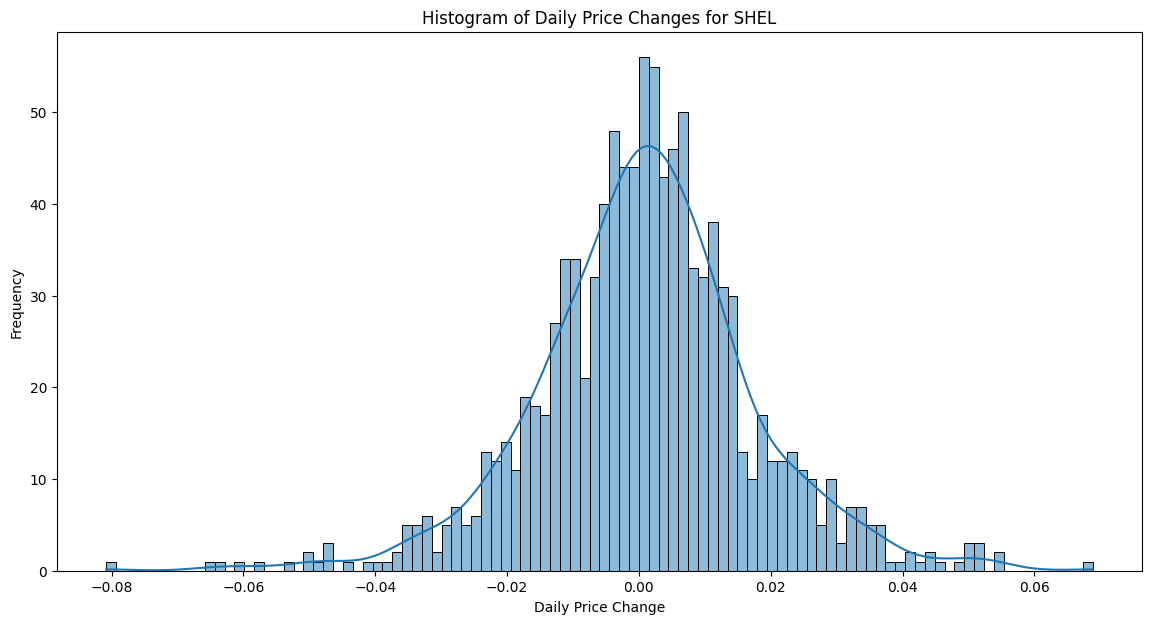

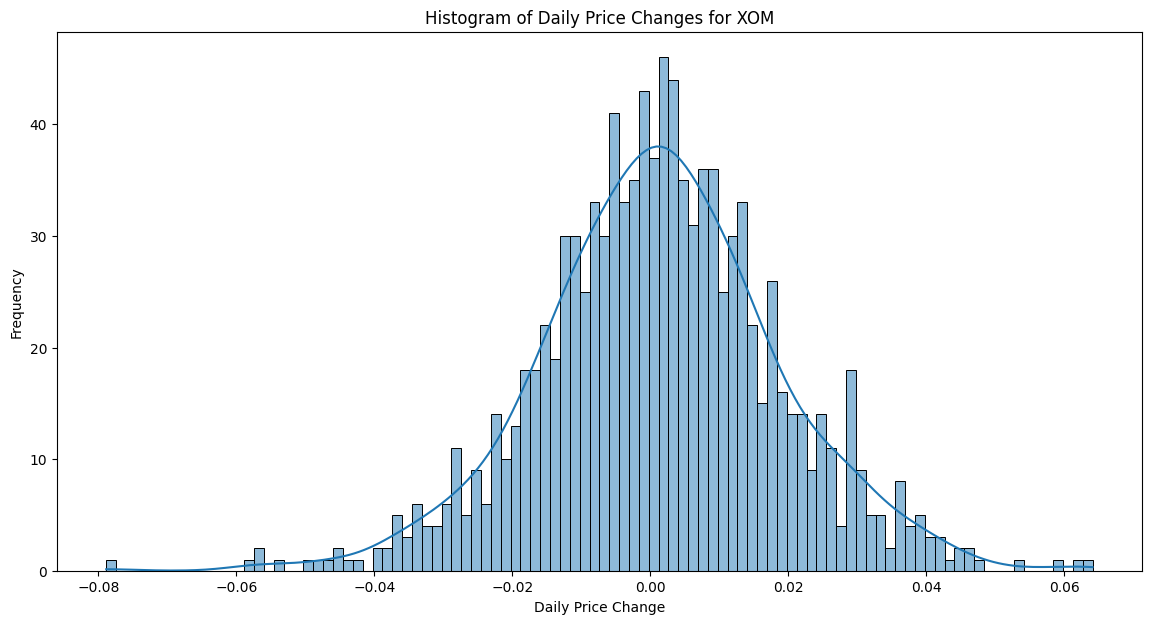

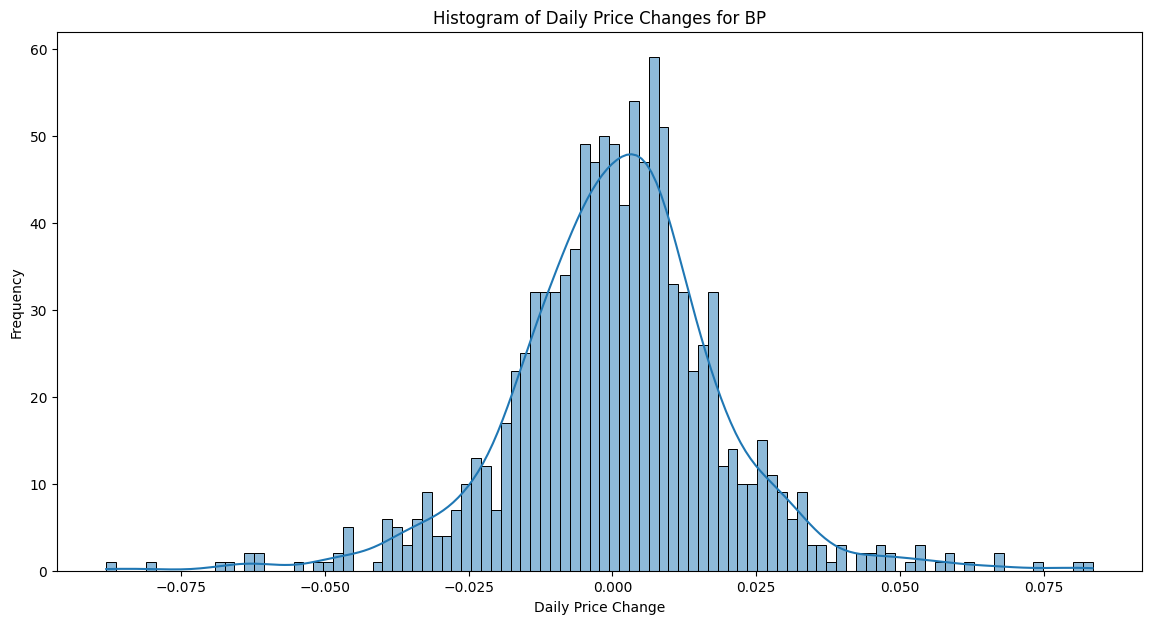

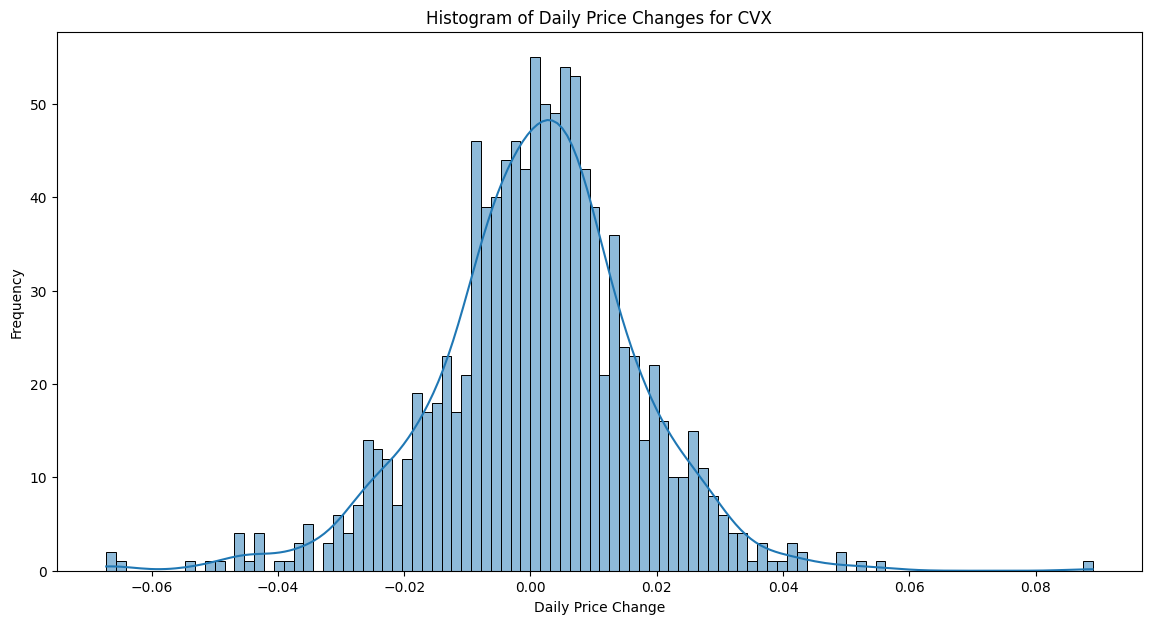

In [35]:
unique_tickers = stock_data['ticker'].unique()

for t in unique_tickers:
    plt.figure(figsize = (14, 7))
    sns.histplot(stock_data[stock_data['ticker'] == t]['price_change'].dropna(), bins = 100, kde = True)
    plt.title(f"Histogram of Daily Price Changes for {t}")
    plt.xlabel('Daily Price Change')
    plt.ylabel('Frequency')
    plt.show()

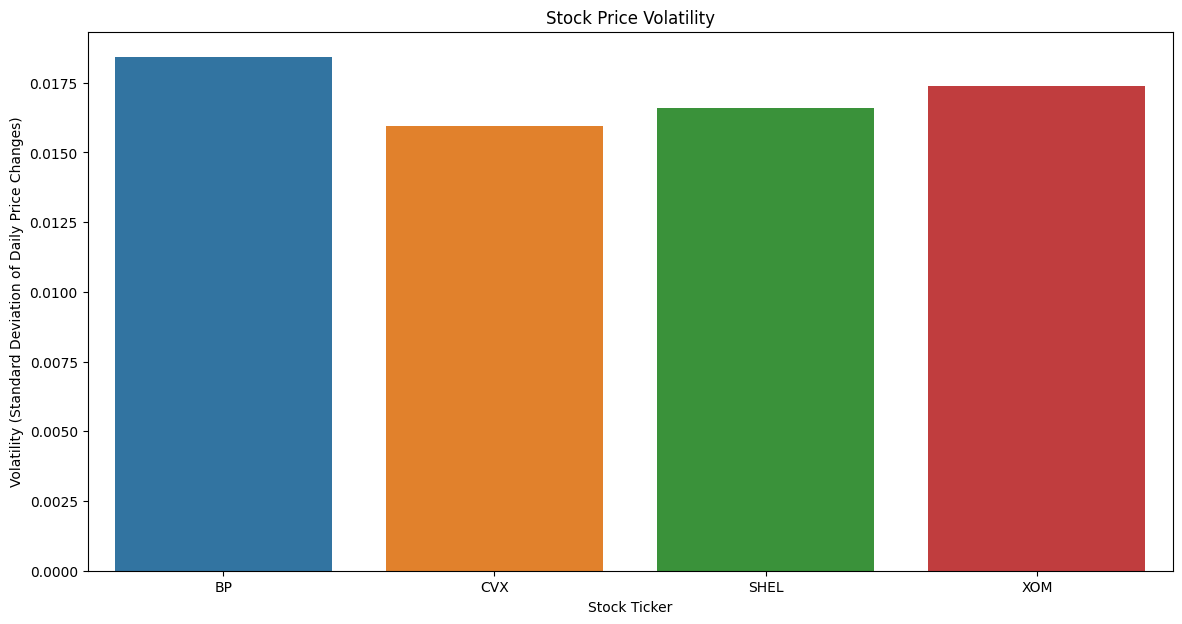

In [36]:
volatility = stock_data.groupby('ticker')['price_change'].std().reset_index()
volatility.columns = ['ticker', 'volatility']

plt.figure(figsize = (14, 7))
sns.barplot(data = volatility, x = 'ticker', y = 'volatility', hue = 'ticker')
plt.title('Stock Price Volatility')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Price Changes)')
plt.show()

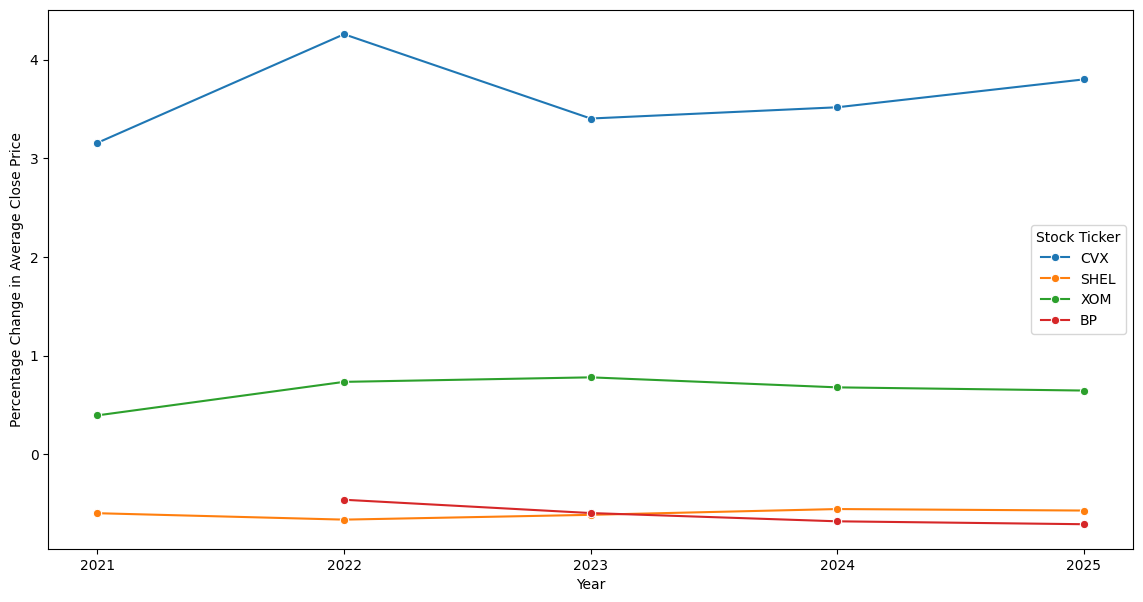

In [37]:
yearly_price_change = stock_data.groupby(['year', 'ticker'])['close'].mean().pct_change().reset_index()
yearly_price_change = yearly_price_change.dropna()

plt.figure(figsize=(14, 7))
sns.lineplot(data = yearly_price_change, x = 'year', y = 'close', hue = 'ticker', marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Average Close Price')
plt.xticks(ticks=yearly_price_change['year'].unique()) # Display integer instead of decimal number as year
plt.legend(title = 'Stock Ticker')
plt.show()

## Shell

In [48]:
shell_stock = stock_data[stock_data['ticker'] == 'SHEL']
shell_stock.set_index('date', inplace = True)

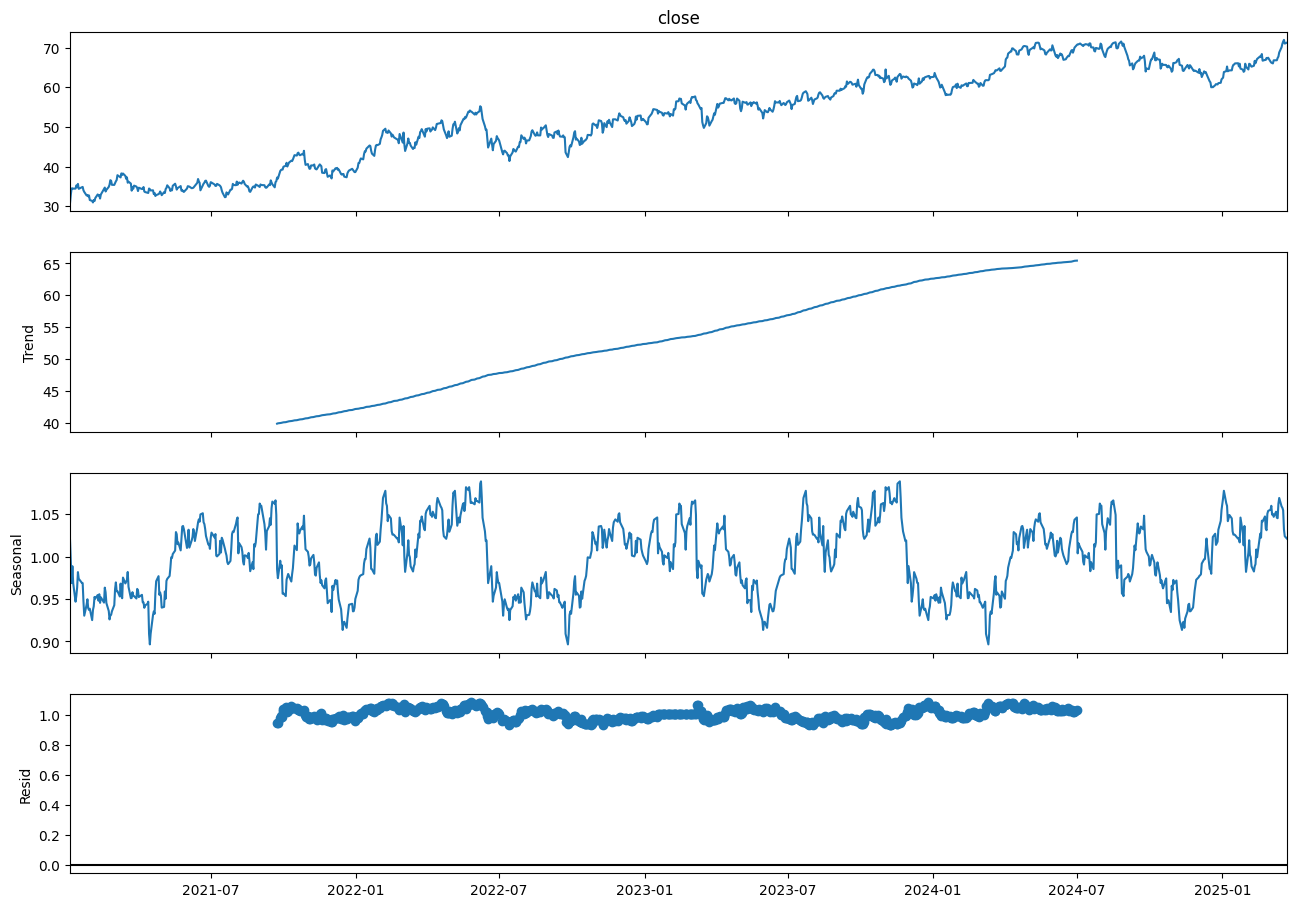

In [49]:
decomposition = seasonal_decompose(shell_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

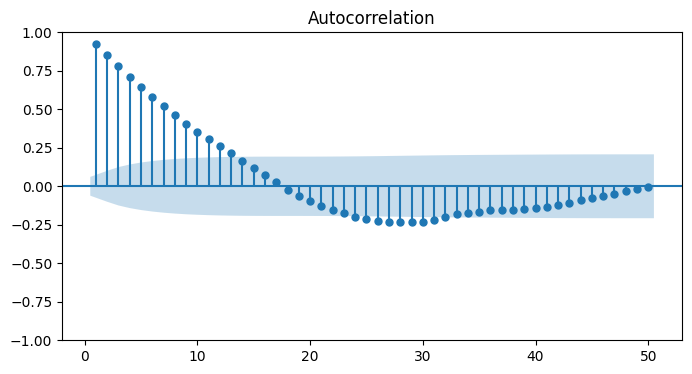

In [65]:
# Subtract long rolling average
detrend = shell_stock['close'] - shell_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

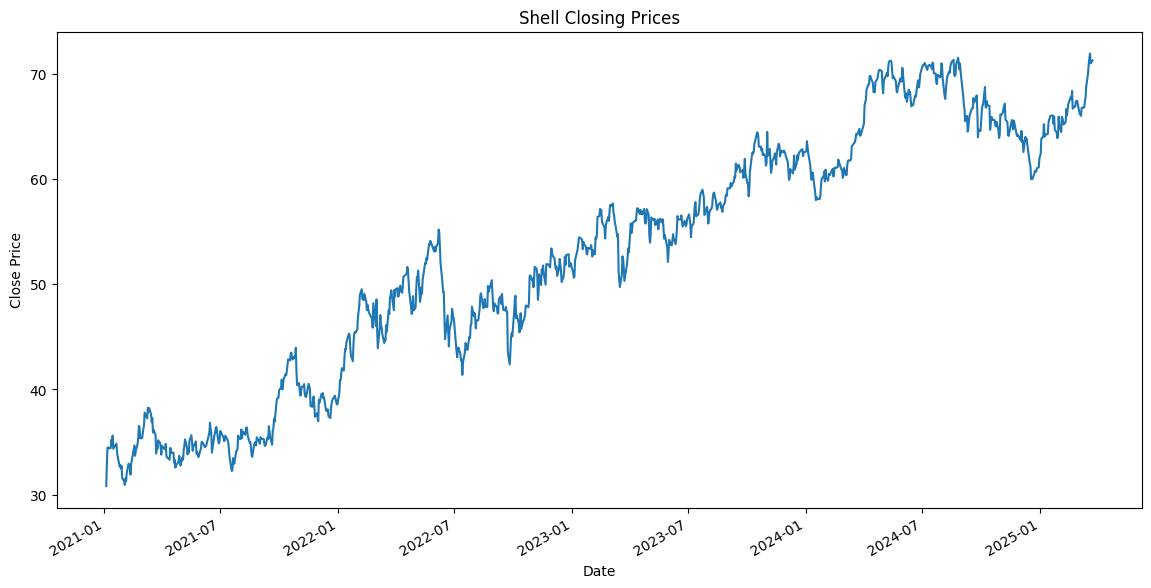

In [40]:
plt.figure(figsize=(14, 7))
shell_stock['close'].plot()
plt.title("Shell Closing Prices")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_8972\1717016293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

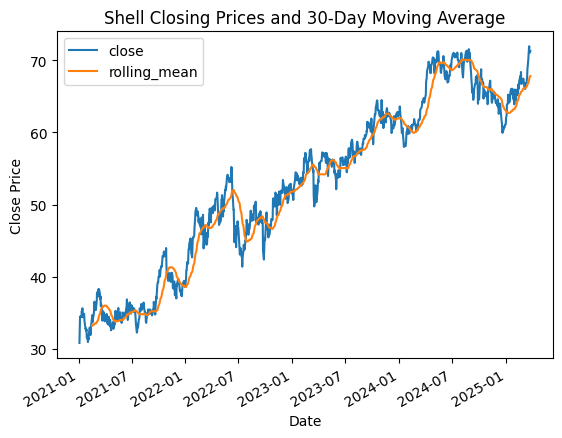

In [41]:
shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()

plt.figure(figsize=(14, 7))
shell_stock[['close', 'rolling_mean']].plot()
plt.title('Shell Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Chevron

In [63]:
cvx_stock = stock_data[stock_data['ticker'] == 'CVX']
cvx_stock.set_index('date', inplace = True)

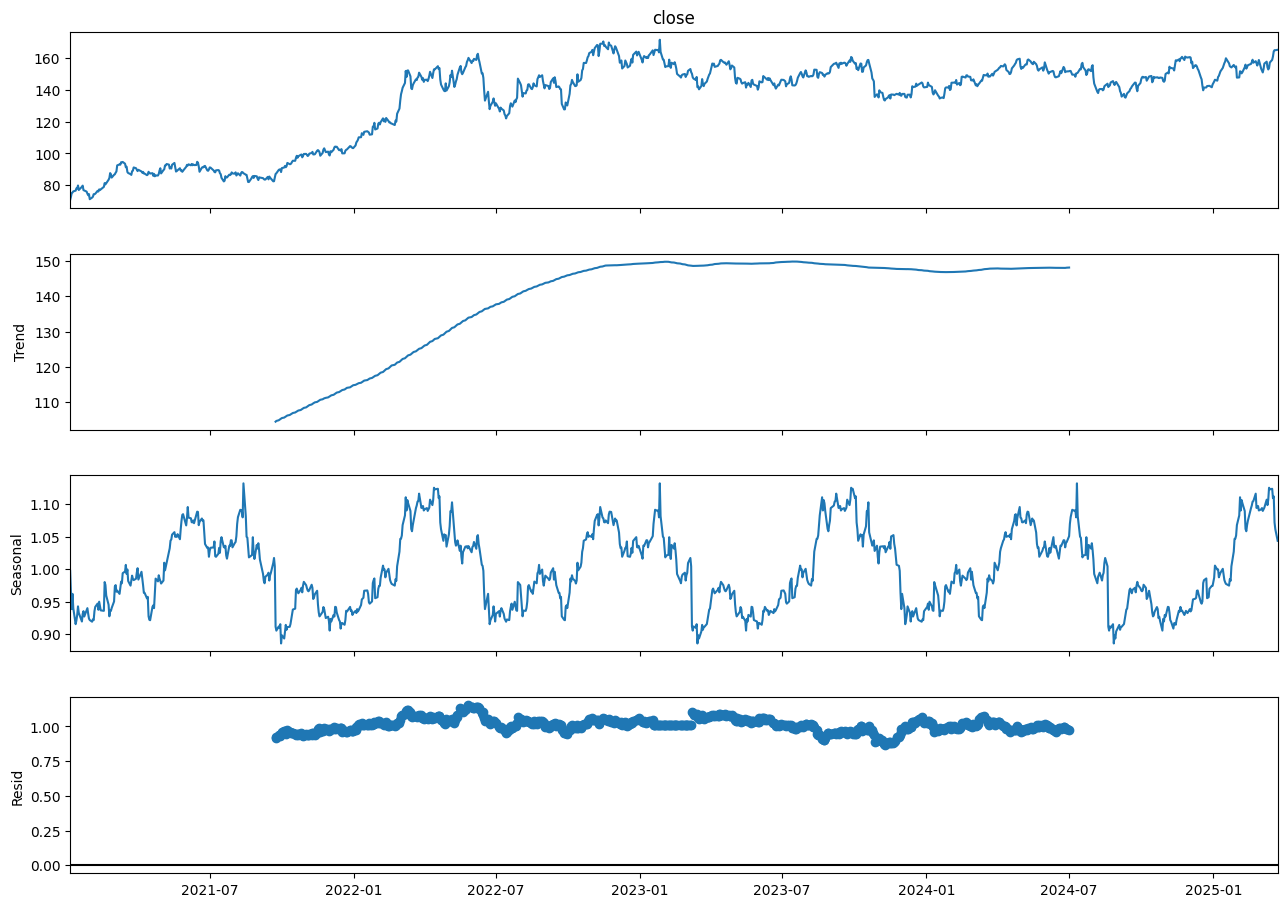

In [43]:
decomposition = seasonal_decompose(cvx_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

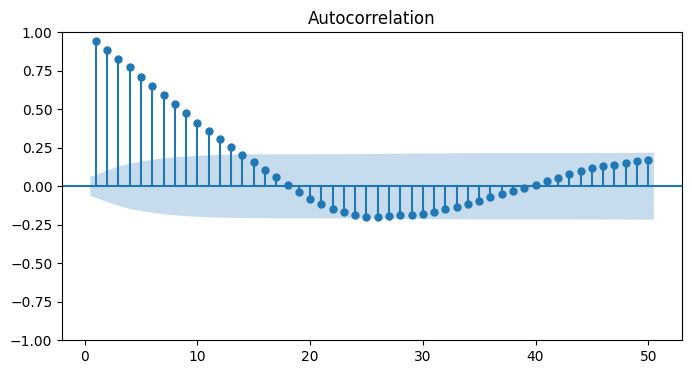

In [66]:
# Subtract long rolling average
detrend = cvx_stock['close'] - cvx_stock['close'].rolling(30).mean()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(detrend.dropna(), ax=ax, lags=50, zero=False)
plt.show()

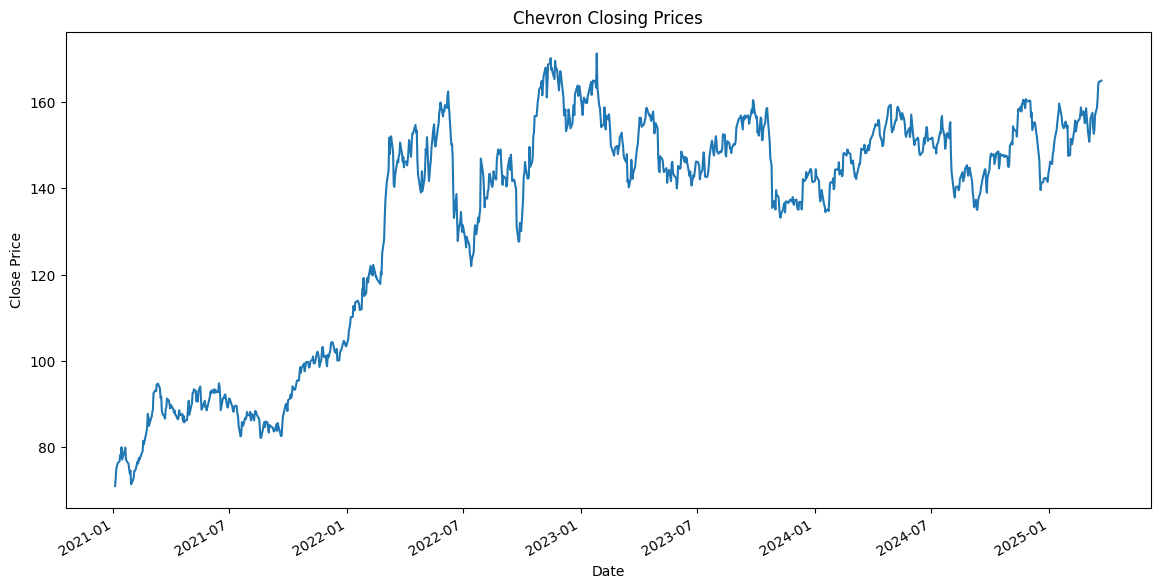

In [44]:
plt.figure(figsize = (14, 7))
cvx_stock['close'].plot()
plt.title('Chevron Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_8972\1352409153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

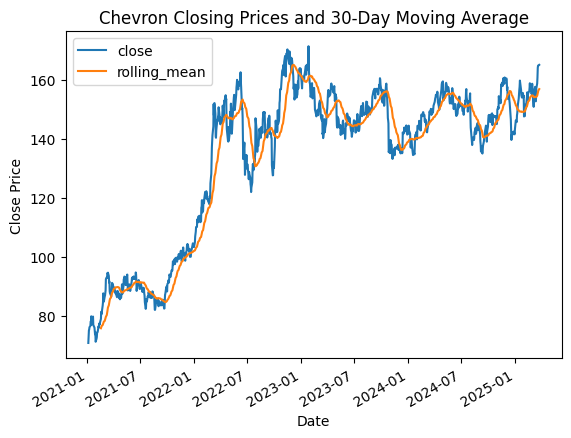

In [45]:
cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()

plt.figure(figsize = (14, 7))
cvx_stock[['close', 'rolling_mean']].plot()
plt.title('Chevron Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Prediction 2.0

adf test_p-value when d = 0: 0.6340253814909458
adf test_p-value when d = 1: 0.0
Final d = 1


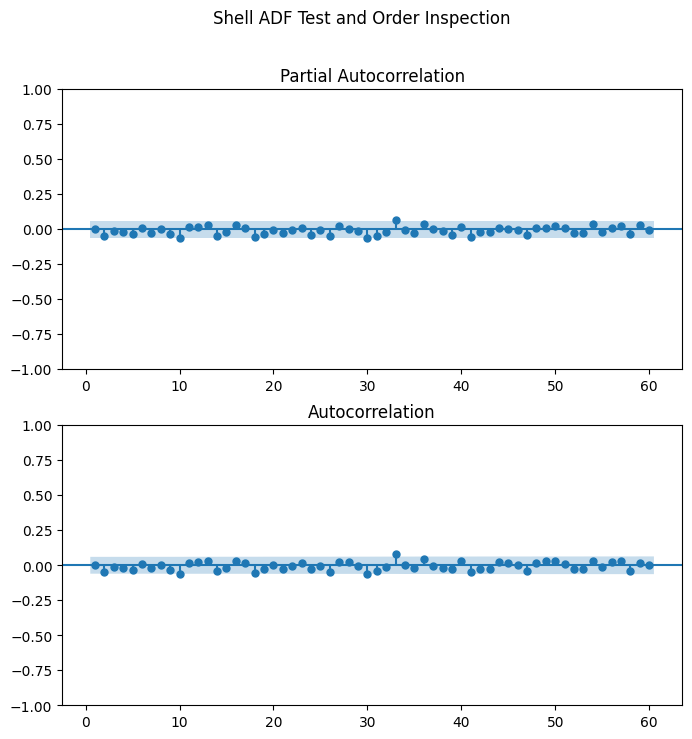

adf test_p-value when d = 0: 0.3589315316124665
adf test_p-value when d = 1: 0.0
Final d = 1


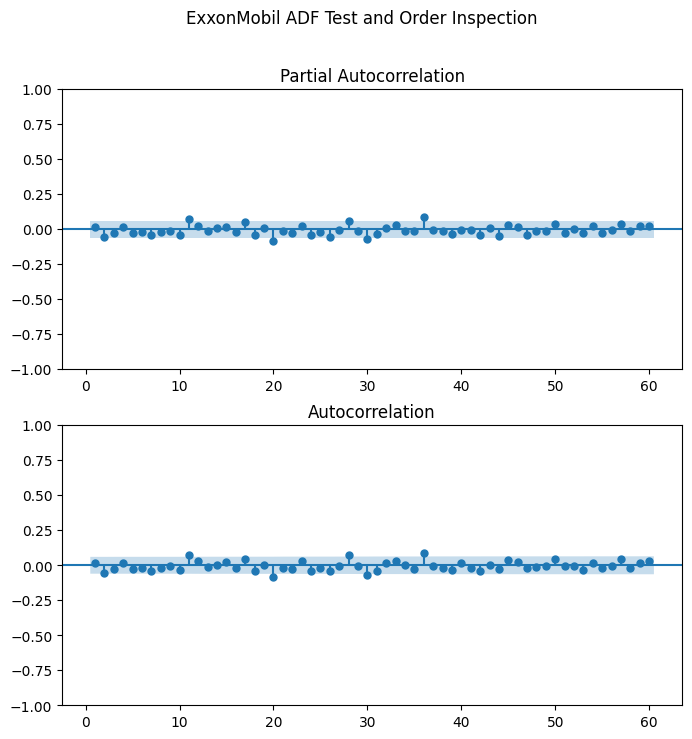

adf test_p-value when d = 0: 0.18858120211117801
adf test_p-value when d = 1: 0.0
Final d = 1


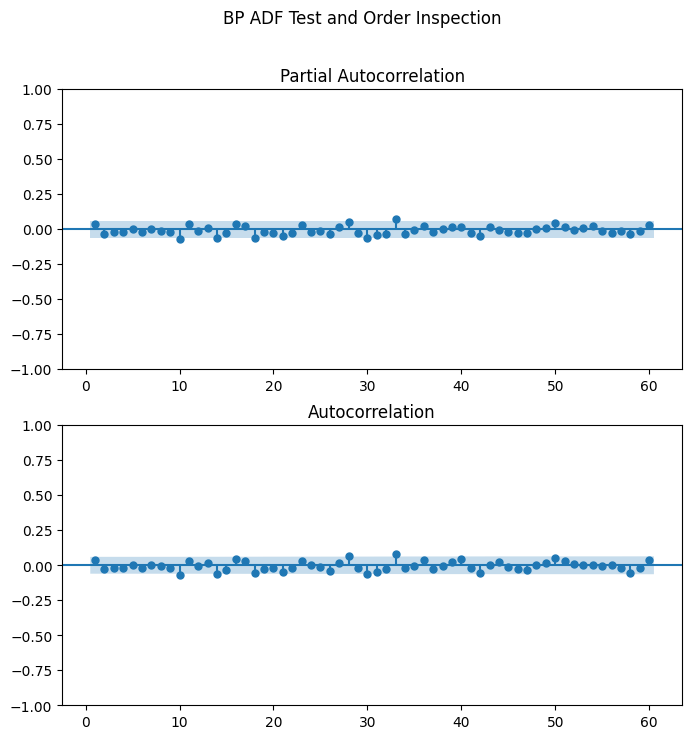

adf test_p-value when d = 0: 0.24643139090466504
adf test_p-value when d = 1: 0.0
Final d = 1


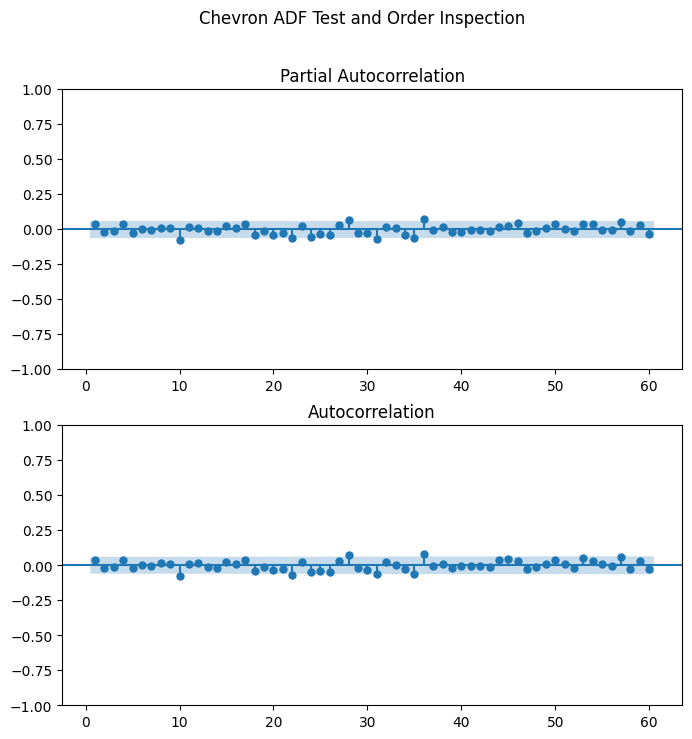

In [12]:

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker'] == ticker]['close']
    adf_result = adfuller(df)[1]
    d = 0
    print(f"adf test_p-value when d = {d}: {adf_result}")
    while adf_result >= 0.05 and d < 2:
        df = df.diff().dropna()
        d += 1
        adf_result = adfuller(df)[1]
        print(f"adf test_p-value when d = {d}: {adf_result}")
    print(f"Final d = {d}")
    fig,(ax1, ax2) = plt.subplots(2, 1, figsize = (8,8))
    fig.suptitle(f"{tickers_names[ticker]} ADF Test and Order Inspection")
    ax1.set_title('PACF')
    ax2.set_title('ACF')
    plot_pacf(df, lags = 60, zero = False, ax = ax1)
    plot_acf(df, lags = 60, zero = False, ax = ax2)
    plt.show()
    

In [27]:
stock_data[stock_data['ticker']=='SHEL']['close'].index


DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2025-03-12', '2025-03-13', '2025-03-14', '2025-03-17',
               '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21',
               '2025-03-24', '2025-03-25'],
              dtype='datetime64[ns]', name='date', length=1061, freq=None)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1061
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1276.393
Date:                Wed, 26 Mar 2025   AIC                           2554.786
Time:                        16:26:16   BIC                           2559.752
Sample:                             0   HQIC                          2556.669
                               - 1061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6508      0.021     30.414      0.000       0.609       0.693
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               123.70
Prob(Q):                              0.98   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

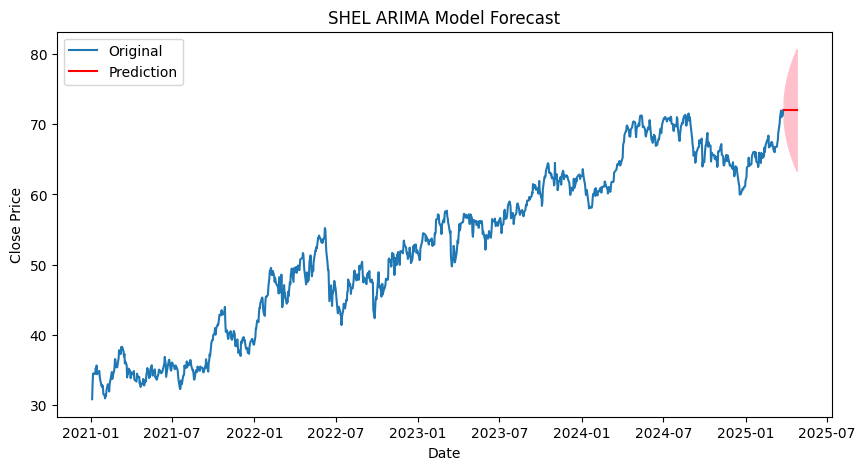

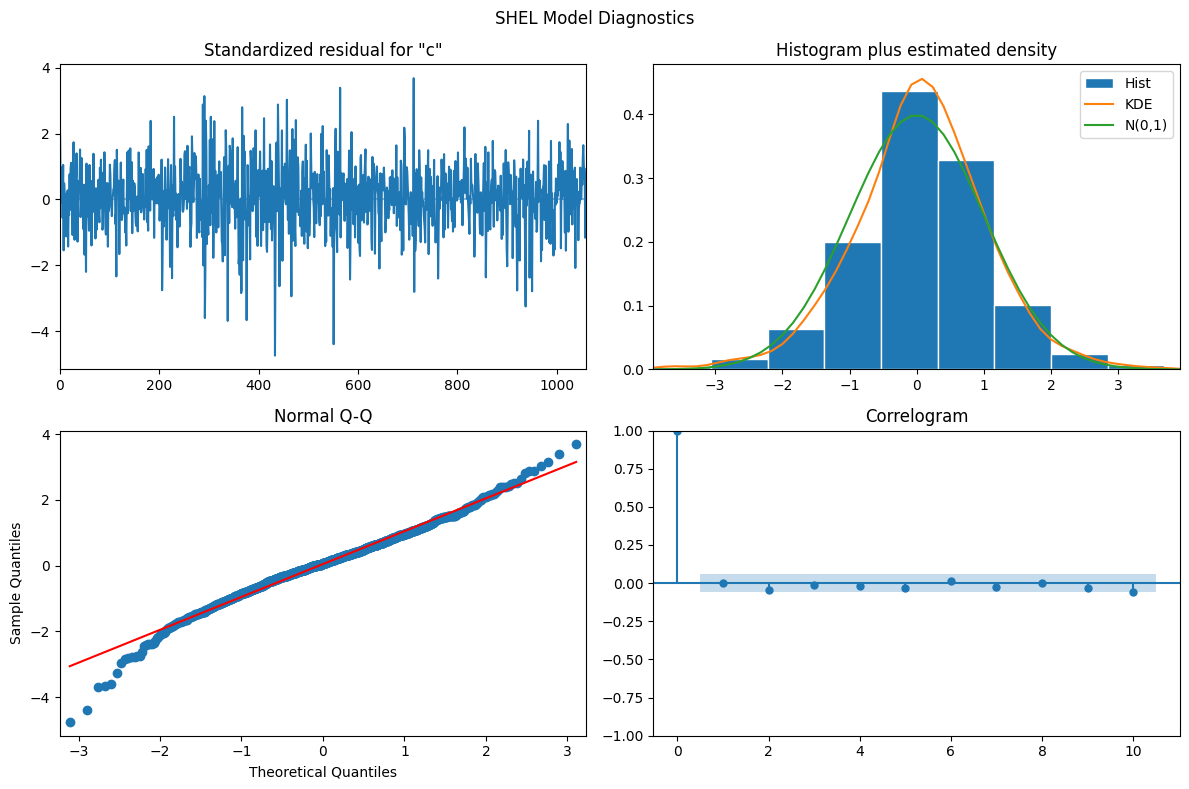

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1061
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1913.442
Date:                Wed, 26 Mar 2025   AIC                           3828.883
Time:                        16:26:17   BIC                           3833.849
Sample:                             0   HQIC                          3830.765
                               - 1061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1649      0.076     28.560      0.000       2.016       2.313
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                62.68
Prob(Q):                              0.55   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

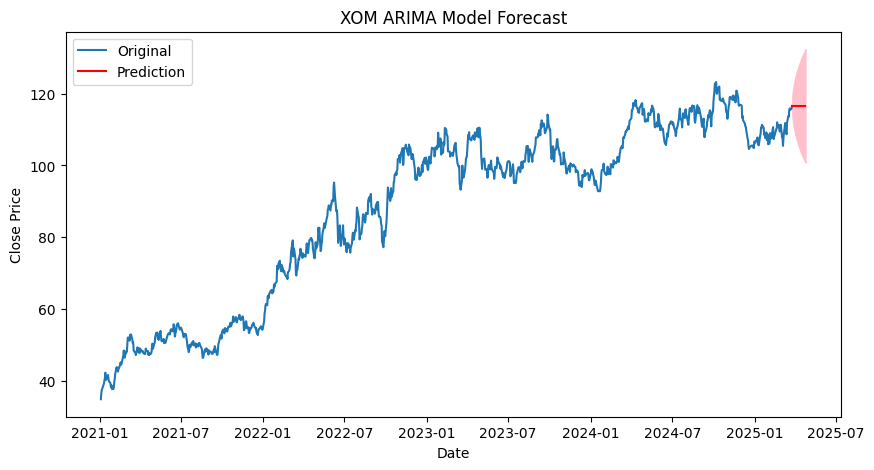

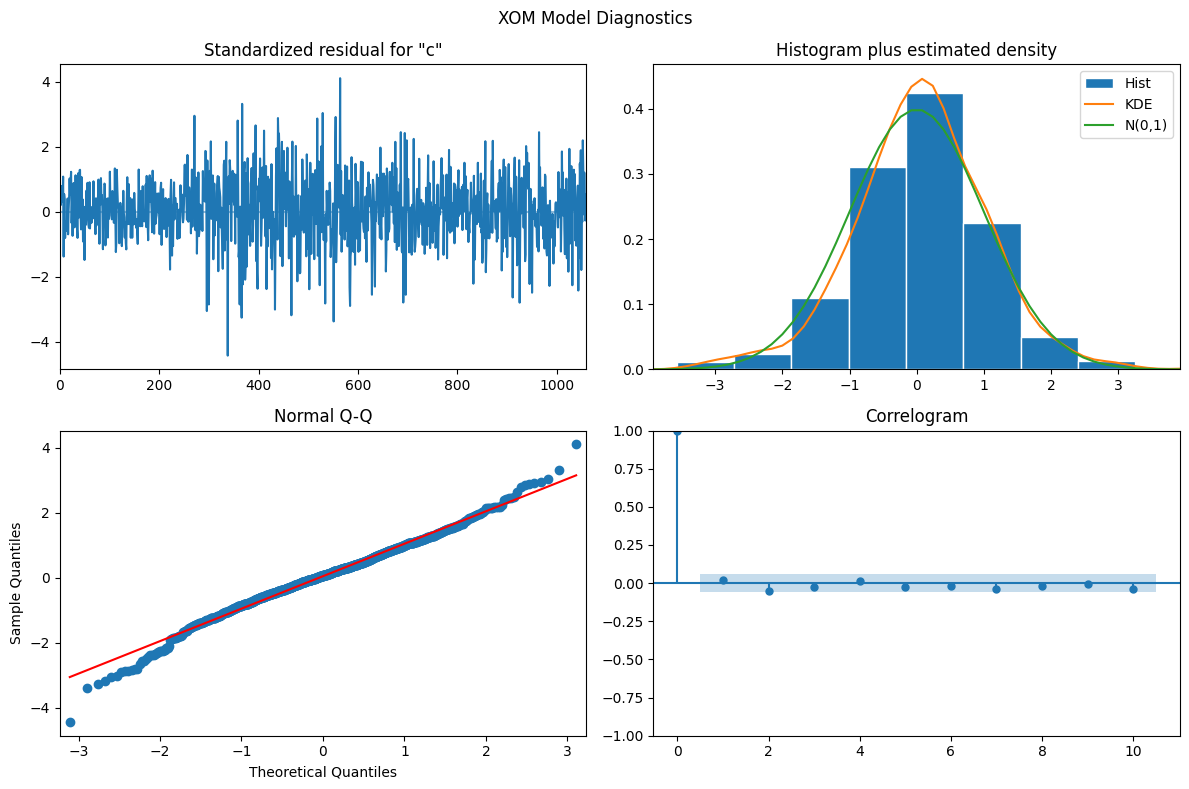

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1061
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -778.394
Date:                Wed, 26 Mar 2025   AIC                           1558.787
Time:                        16:26:18   BIC                           1563.753
Sample:                             0   HQIC                          1560.669
                               - 1061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2543      0.007     37.332      0.000       0.241       0.268
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):               494.75
Prob(Q):                              0.22   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

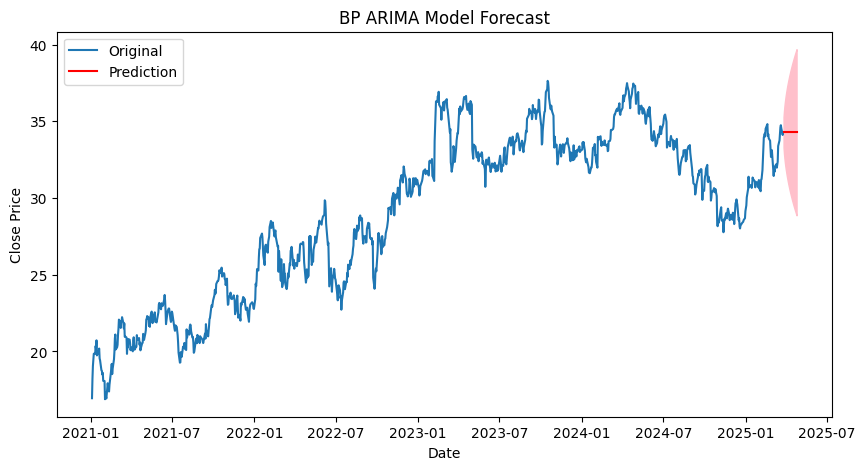

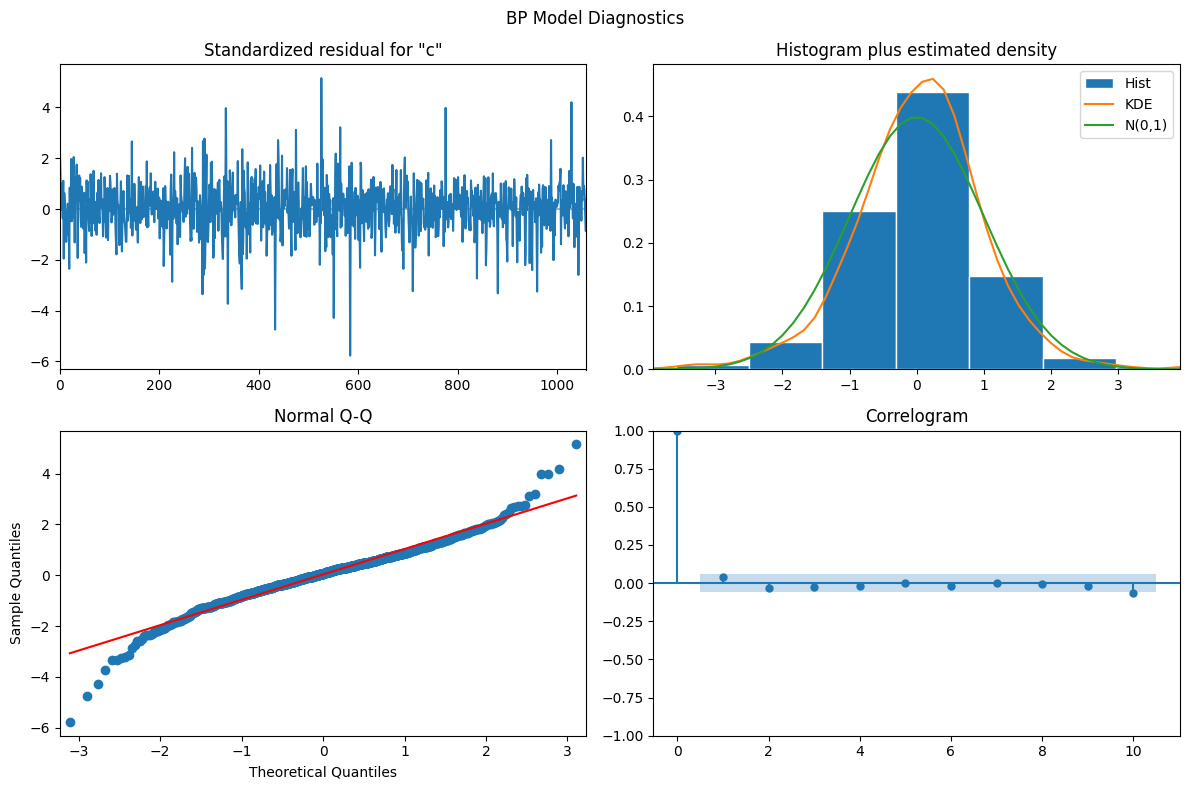

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1061
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2318.510
Date:                Wed, 26 Mar 2025   AIC                           4639.019
Time:                        16:26:19   BIC                           4643.985
Sample:                             0   HQIC                          4640.901
                               - 1061                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.6491      0.130     35.672      0.000       4.394       4.904
Ljung-Box (L1) (Q):                   1.73   Jarque-Bera (JB):               387.90
Prob(Q):                              0.19   Pr

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

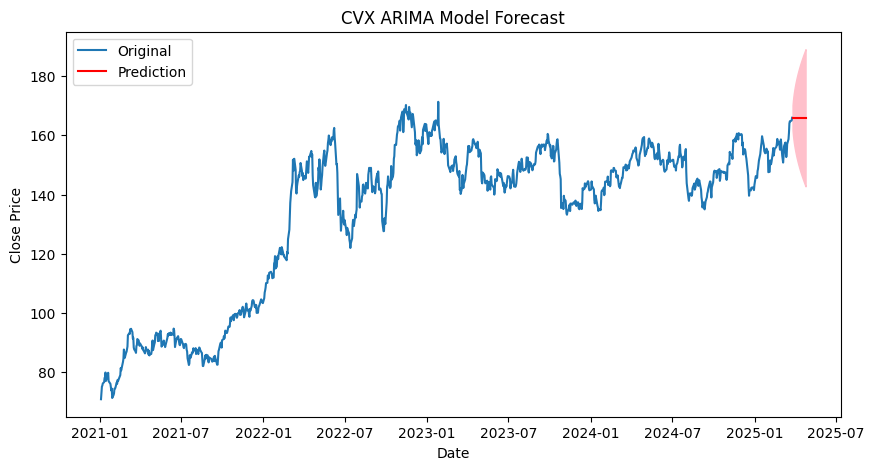

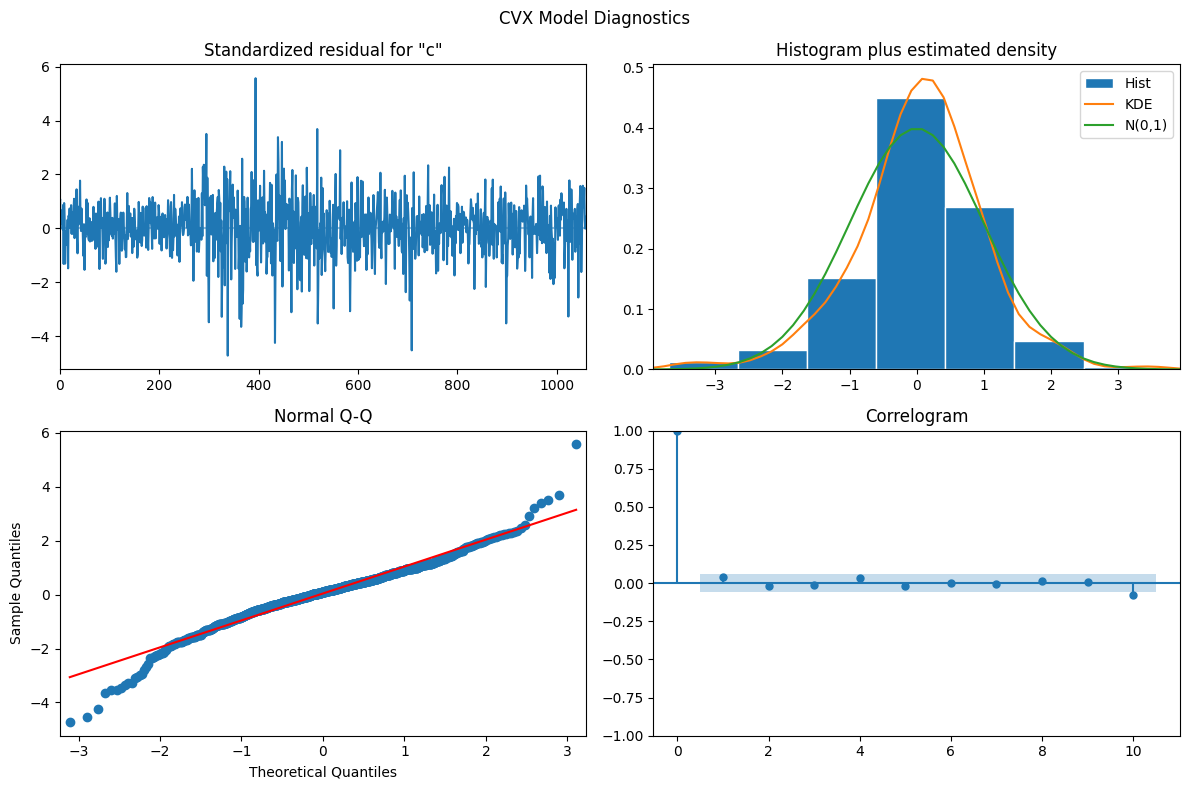

In [31]:

for ticker in list(tickers_names.keys()):
    df = stock_data[stock_data['ticker']==ticker]['close']

    model = ARIMA(df, order = (0,1,0))
    results = model.fit()
    print(results.summary())

    predict = results.get_forecast(steps = 30)
    last_date = stock_data[stock_data['ticker'] == ticker].index.max()
    predict_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    # predict_index = pd.date_range(start = df[-1], periods = 30, freq = 'D')
    predict_mean = predict.predicted_mean
    predict_conf_int = predict.conf_int()

    plt.figure(figsize = (10,5))
    plt.plot(df, label = 'Original')
    plt.plot(predict_index, predict_mean, color = 'red', label = 'Prediction')
    plt.fill_between(predict_index, predict_conf_int.iloc[:,0], predict_conf_int.iloc[:,1], color = 'pink')
    plt.title(f"{ticker} ARIMA Model Forecast")
    plt.xlabel("Date")
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    diag_fig = results.plot_diagnostics(figsize = (12, 8))
    diag_fig.suptitle(f"{ticker} Model Diagnostics")
    plt.tight_layout()
    plt.show()






In [87]:
shell = shell_stock['close']
shell_model = ARIMA(shell.iloc[:len(shell)-30], order = (0,1,0))
results = shell_model.fit()

diff_forecast = results.get_forecast(steps = 30).predicted_mean
from numpy import cumsum
mean_forecast = cumsum(diff_forecast) + shell.iloc[-1]

d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Side Projects\Energy Stock\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

# Prediction


### SHEL ###
Validation: found setting (2, 0, 1). Test RMSE: 3.135


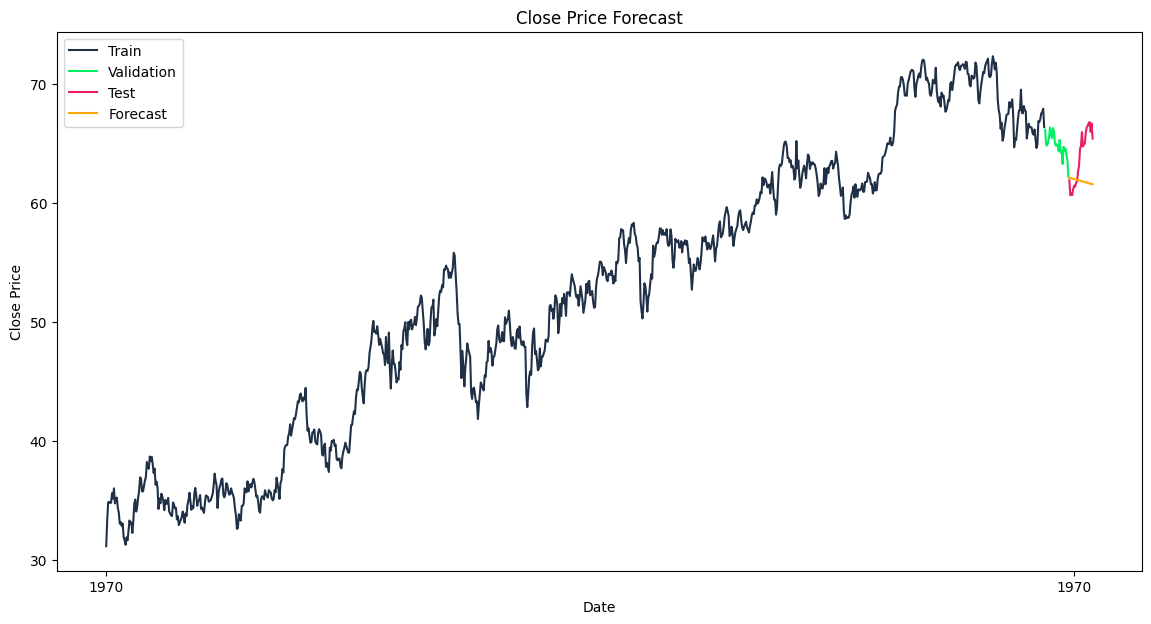


### XOM ###
Validation: found setting (2, 0, 4). Test RMSE: 2.121


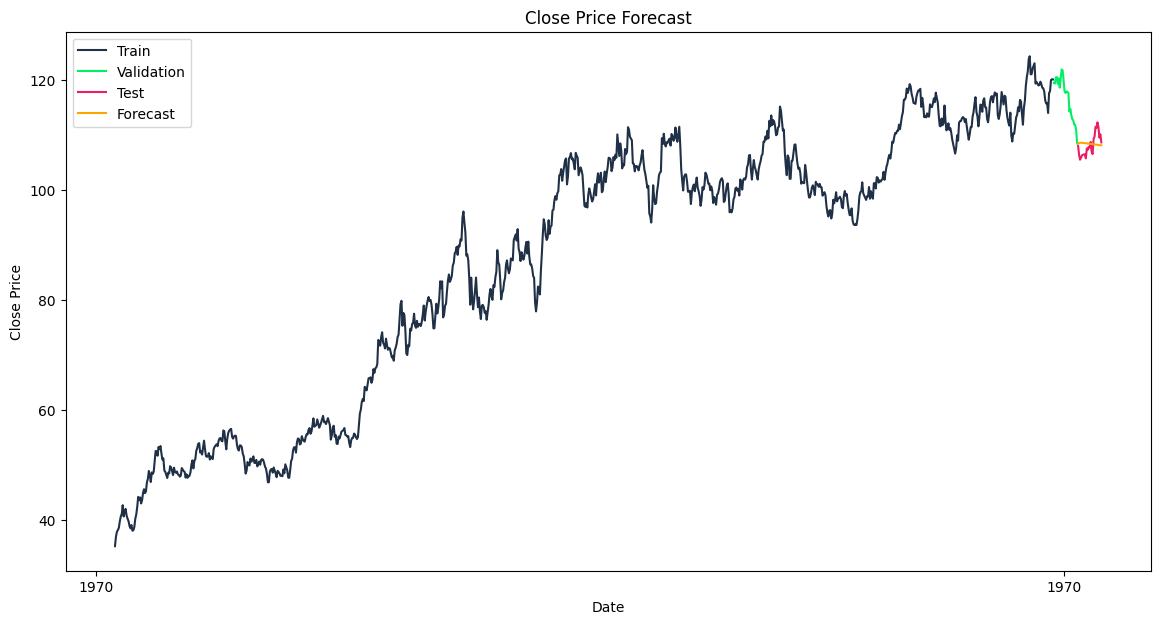


### BP ###
Validation: found setting (3, 1, 4). Test RMSE: 1.675


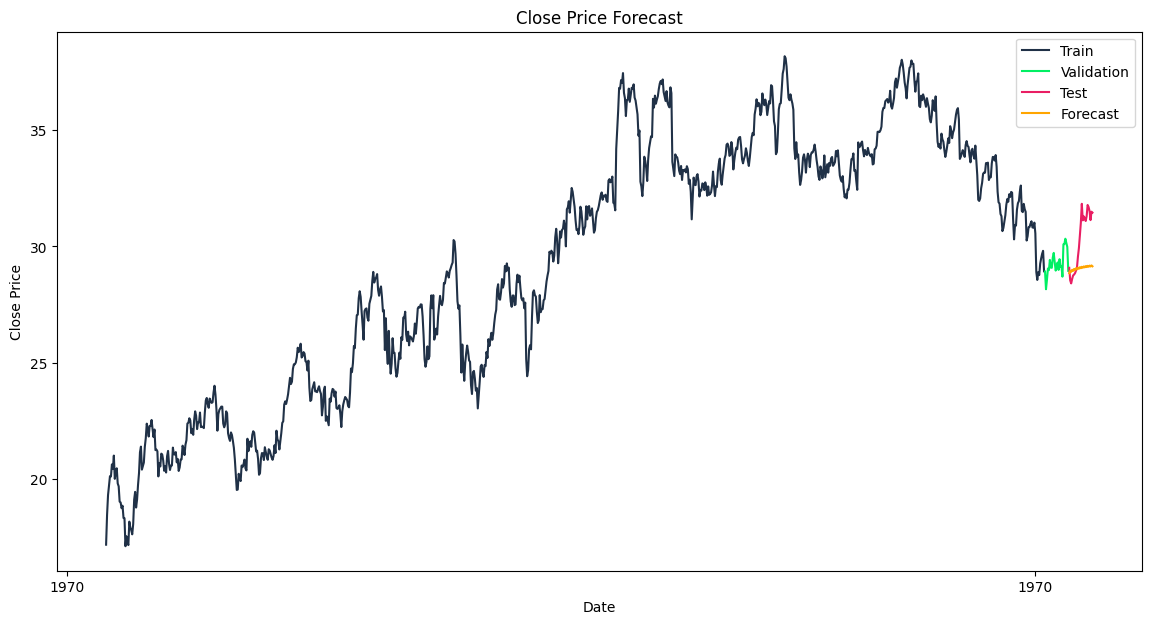


### CVX ###
Validation: found setting (0, 2, 0). Test RMSE: 70.560


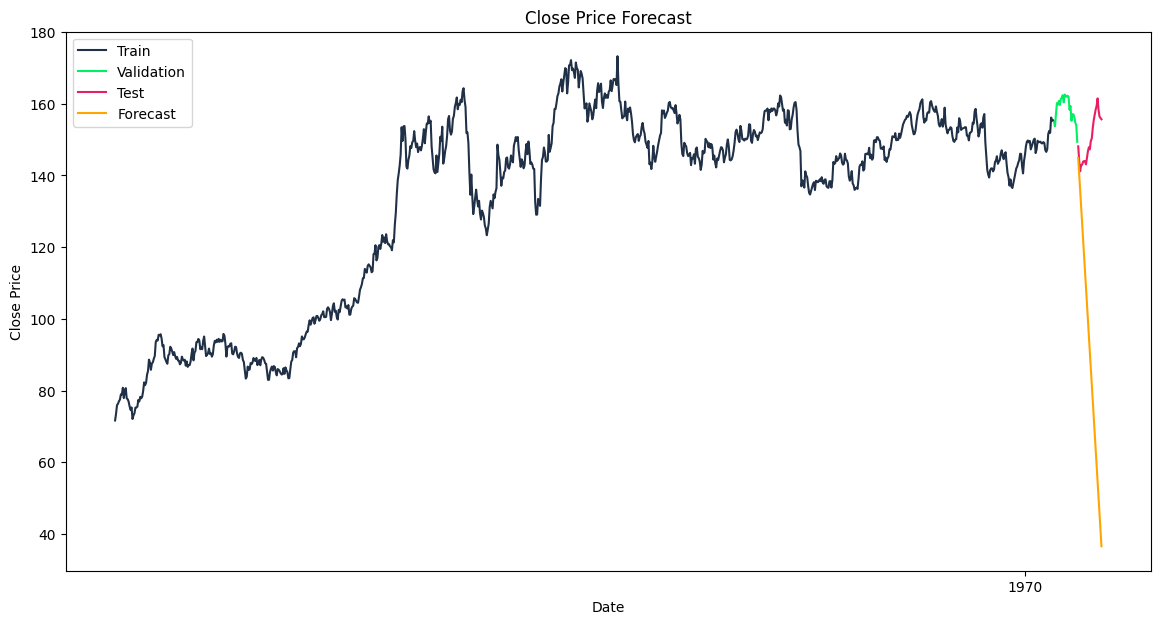

In [27]:
# Don't delete it.
# https://www.datacamp.com/tutorial/arima

import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Function to calculate RMSE
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Load the data (ensure it's already prepared and clean)
data = stock_data.copy()  # Replace with your dataset variable
symbols = stock_data['ticker'].unique()  # Assuming you have a 'ticker' column for multiple stocks

# Loop through each symbol
for symbol in symbols:
    print(f"\n### {symbol} ###")
    symbol_data = data[data['ticker'] == symbol]  # Filter data for the current symbol
    symbol_data.index = pd.to_datetime(symbol_data.index)
    symbol_data = symbol_data.sort_index()  # Ensure the data is sorted by date
    time_series = symbol_data['close']

    # Train-validation-test split
    val_size = 25  # Number of validation points
    test_size = 25  # Number of test points
    train_size = len(time_series) - val_size - test_size

    trn = time_series[:train_size]
    val = time_series[train_size:train_size + val_size]
    tst = time_series[train_size + val_size:]

    # Find the best (p, d, q) parameters
    min_loss = np.inf
    val_settings = ()

    # Hyperparameter grid search
    for p, d, q in itertools.product(range(0, 5), range(0, 3), range(0, 5)):
        try:
            model = ARIMA(trn, order=(p, d, q))
            model_fit = model.fit()

            # Validate on the validation set
            prd = model_fit.predict(start=len(trn), end=len(trn) + len(val) - 1)
            loss = rmse(val, prd)

            if loss < min_loss:
                min_loss = loss
                val_settings = (p, d, q)
        except:
            # Skip invalid models
            continue

    # Train the model on the full dataset (train + validation) using the best parameters
    trn_val = pd.concat([trn, val])  # Combine trn and val as a pandas Series
    val_model = ARIMA(trn_val, order=val_settings)
    val_fit = val_model.fit()

    # Test predictions
    forecast = val_fit.forecast(steps=len(tst))
    test_rmse = rmse(tst, forecast)
    print(f'Validation: found setting {val_settings}. Test RMSE: {test_rmse:.3f}')

    # Plot the results with specified colors
    plt.figure(figsize=(14, 7))
    plt.plot(trn.index, trn, label='Train', color='#203147')
    plt.plot(val.index, val, label='Validation', color='#01ef63')
    plt.plot(tst.index, tst, label='Test', color='#E91E63')
    plt.plot(tst.index, forecast, label='Forecast', color='orange')
    plt.title('Close Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()


## Course Method

In [226]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Function to calculate RMSE
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Load the data (assume it's already prepared)
data = shell_stock.copy()  # Replace with your dataset variable
# data = data.set_index('date')  # Ensure 'date' is the index
data.index = pd.to_datetime(data.index)
# data = data.asfreq('D')  # Adjust frequency ('D' for daily)
data = data.sort_index()  # Ensure the data is sorted by date

# Use the 'close' column for modeling
time_series = data['close']

# Train-validation-test split
val_size = 25  # Number of validation points
test_size = 25  # Number of test points
train_size = len(time_series) - val_size - test_size

trn = time_series[:train_size]
val = time_series[train_size:train_size + val_size]
tst = time_series[train_size + val_size:]

# Find the best (p, d, q) parameters
min_loss = np.inf
val_settings = ()

# Hyperparameter grid search
for p, d, q in itertools.product(range(0, 5), range(0, 3), range(0, 5)):
    try:
        model = ARIMA(trn, order=(p, d, q))
        model_fit = model.fit()

        # Validate on the validation set
        prd = model_fit.predict(start=len(trn), end=len(trn) + len(val) - 1)
        loss = rmse(val, prd)

        if loss < min_loss:
            min_loss = loss
            val_settings = (p, d, q)
    except:
        # Skip invalid models
        continue

# Train the model on the full dataset (train + validation) using the best parameters
val_model = ARIMA(np.hstack((trn, val)), order=val_settings)
val_fit = val_model.fit()

# Test predictions
val_prd = val_fit.predict(start=len(trn) + len(val), end=len(trn) + len(val) + len(tst) - 1)
test_rmse = rmse(tst, val_prd)
print(f'Validation: found setting {val_settings}. Test RMSE: {test_rmse:.3f}')

# Forecast future values
forecast_steps = 30  # Predict the next 30 days
future_forecast = val_fit.forecast(steps=forecast_steps)

# Display forecast
print(f"Next {forecast_steps} days forecast:")
print(future_forecast)


Validation: found setting (2, 0, 1). Test RMSE: 3.167
Next 30 days forecast:
[62.08864087 62.08445108 62.04487696 62.02733338 61.99620385 61.9735823
 61.94576299 61.92124788 61.89476278 61.86957929 61.84366778 61.81828714
 61.79265629 61.76725961 61.74179647 61.71645321 61.69111408 61.66585074
 61.6406186  61.61544516 61.59031321 61.56523327 61.54019868 61.51521342
 61.49027487 61.46538451 61.44054128 61.41574568 61.39099726 61.36629615]
